In [1]:
%load_ext autoreload
%autoreload 2
from astropy.table import Table
import pandas as pd
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
import sys
from tqdm.auto import tqdm, trange
sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/modules/')
import simulation as simulation
import pinocchio_binning_scheme as binning_scheme
import pyccl as ccl
from multiprocessing import Pool
import model_halo_abundance as cl_count
from matplotlib.cm import get_cmap
import pickle

def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Initialize SBI object

In [2]:
stacked_simulator_pl = simulation.Universe_simulation( 'stacked_counts' ,
                                                        variable_params=['omega_m', 
                                                                         'sigma_8', 
                                                                         'h',
                                                                         'alpha' , 
                                                                         'c' , 
                                                                         'beta',
                                                                         'sigma' ],
                                                        fixed_params={'w_0': -1, 'w_a': 0 } )

stacked_simulator_pl.selection_richness = 0
def dOmega_z(z): return 0.25 * 4 * np.pi
stacked_simulator_pl.dOmega = dOmega_z
stacked_simulator_pl.richness_bins = None
stacked_simulator_pl.redshift_bins = None
stacked_simulator_pl.sigma_mwl = 0
stacked_simulator_pl.include_mwl_measurement_errors = False
stacked_simulator_pl.correlation_mass_evolution = False
stacked_simulator_pl.set_richness_mass_relation( 'constantins model' )
stacked_simulator_pl.set_bins( z_bins = np.arange( 0.2 , 1 , 0.001 ) , 
                               log10m_bins=  np.arange( 13.5 , 15.5 , 0.001))
stacked_simulator_pl.massdef = ccl.halos.massdef.MassDef('vir', 'critical',)
stacked_simulator_pl.f_sky = 0.25
stacked_simulator_pl.hmd = ccl.halos.hmfunc.MassFuncDespali16( mass_def=stacked_simulator_pl.massdef)
stacked_simulator_pl.add_SSC = True
stacked_simulator_pl.Z_edges_SSC = np.linspace(0.2, 1, 6)
stacked_simulator_pl.Z_bin_SSC = [[stacked_simulator_pl.Z_edges_SSC[i], stacked_simulator_pl.Z_edges_SSC[i+1]] for i in range(len(stacked_simulator_pl.Z_edges_SSC)-1)]

# Compute (or load) fiducial Sij matrix

In [3]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711

cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

def compute_Sij_matrix(cosmo, Z_bin_SSC, f_sky = 1):
    import cluster_abundance_covariance as cl_covar
    CLCovar = cl_covar.Covariance_matrix()
    Sij_partialsky_exact_standard = CLCovar.compute_theoretical_Sij(Z_bin_SSC, cosmo, 
                                                                f_sky,
                                                                S_ij_type='full_sky_rescaled_approx', 
                                                                path=None)
    return Sij_partialsky_exact_standard

In [4]:
have_PySSC = False

In [5]:
if have_PySSC:
    stacked_simulator_pl.Sij_SSC = compute_Sij_matrix(cosmo, stacked_simulator_pl.Z_bin_SSC)/stacked_simulator_pl.f_sky
    save_pickle(stacked_simulator_pl.Sij_SSC*stacked_simulator_pl.f_sky, f'/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_matrix/S_ij_full_sky.pkl', )
else: 
    S_ij_full_sky = load(f'/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_matrix/S_ij_full_sky.pkl' )
    stacked_simulator_pl.Sij_SSC = S_ij_full_sky/stacked_simulator_pl.f_sky

# Generate mass-redshift catalogue with SSC

In [6]:
%time z, log10m = stacked_simulator_pl.get_cluster_catalogue(cosmo, add_SSC = True)

CPU times: user 5.1 s, sys: 102 ms, total: 5.2 s
Wall time: 1.36 s


In [7]:
Ncount_obs, a, b = np.histogram2d(z, log10m, bins = [binning_scheme.redshift_edges, binning_scheme.logm_edges])

# Compare to standard approach

In [8]:
logm_edges = binning_scheme.logm_edges
redshift_edges = binning_scheme.redshift_edges
richness_edges = binning_scheme.richness_edges
Z_bin = binning_scheme.Z_bin
LogMass_bin = binning_scheme.LogMass_bin
Richness_bin = binning_scheme.Richness_bin

In [9]:
Z_bin, LogMass_bin

([[0.2, 0.36],
  [0.36, 0.52],
  [0.52, 0.6799999999999999],
  [0.6799999999999999, 0.8400000000000001],
  [0.8400000000000001, 1.0]],
 [[14.3, 14.600000000000001],
  [14.600000000000001, 14.9],
  [14.9, 15.2],
  [15.2, 15.5]])

In [10]:
massdef = ccl.halos.massdef.MassDef('vir', 'critical',)
hmd = ccl.halos.hmfunc.MassFuncDespali16( mass_def=massdef)
clc = cl_count.ClusterAbundance()
z_grid = np.linspace(0.2, 1., 500)
logm_grid = np.linspace(14.3, 15.5, 501)
clc.set_cosmology(cosmo = cosmo, hmd = hmd, massdef = massdef)
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
clc.sky_area = stacked_simulator_pl.f_sky * 4 * np.pi
Ncount_th = clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = LogMass_bin, method = 'simps')

In [11]:
np.sum(Ncount_obs), np.sum(Ncount_th)

(51100.0, 51345.01566408237)

# Check counts per mass-redshift bins

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


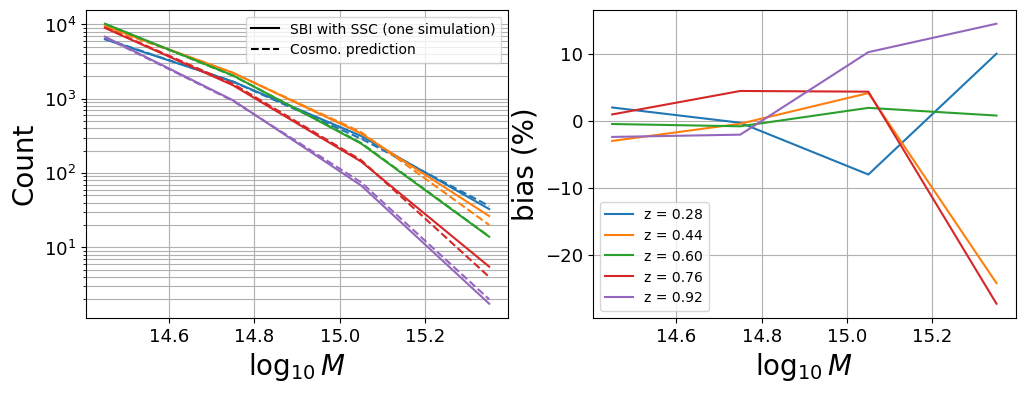

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(121)

for i in range(len(Z_bin)):
    from_sim = Ncount_obs.T[:,i]
    from_pred = Ncount_th[i,:]
    plt.plot(np.mean(LogMass_bin, axis=1), from_pred, '-' + 'C' + str(i))
    plt.plot(np.mean(LogMass_bin, axis=1), from_sim, '--' + 'C' + str(i))
plt.ylabel('Count', fontsize=20,)
plt.xlabel(r'$\log_{10}M$', fontsize=20,)
plt.grid(which='both')
plt.tick_params(axis='both', which = 'major', labelsize= 13)
plt.legend(fontsize=12)
plt.yscale('log')
plt.plot([], [], ls='-', color='k', label = 'SBI with SSC (one simulation)')
plt.plot([], [], '--k', label = 'Cosmo. prediction')
plt.legend()

plt.subplot(122)

for i in range(len(Z_bin)):
    from_sim = Ncount_obs.T[:,i]
    from_pred = Ncount_th[i,:]
    plt.plot(np.mean(LogMass_bin, axis=1), 100*(from_sim- from_pred)/from_pred, '-' + 'C' + str(i),  label = 'z = '+f'{np.mean(Z_bin[i]):.2f}')
plt.ylabel('bias (%)', fontsize=20,)
plt.xlabel(r'$\log_{10}M$', fontsize=20,)
plt.grid(which='both')
plt.tick_params(axis='both', which = 'major', labelsize= 13)
plt.legend(fontsize=12)
plt.legend()

# Check variance

In [13]:
halobias_fct = ccl.halos.hbias.tinker10.HaloBiasTinker10(mass_def=massdef)#, mass_def_strict=True)
clc.compute_halo_bias_grid_MZ(z_grid = z_grid, logm_grid = logm_grid, halobiais = halobias_fct)
NHalo_bias = clc.Nhalo_bias_MZ(Redshift_bin = Z_bin, Proxy_bin = LogMass_bin, method = 'simps')
if have_PySSC:
    Sij = compute_Sij_matrix(cosmo, Z_bin, f_sky = 1)/stacked_simulator_pl.f_sky
    import cluster_abundance_covariance as cl_covar
    CLCovar = cl_covar.Covariance_matrix()
    Sample_covariance = CLCovar.sample_covariance_full_sky(Z_bin, LogMass_bin, NHalo_bias, Sij)
    save_pickle(Sample_covariance, f'/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_matrix/NiNjbibjS_ij_full_sky.pkl' )
else:
    Sample_covariance = load(f'/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_matrix/NiNjbibjS_ij_full_sky.pkl' )

In [14]:
def run_sim(i):
    redshift, log10mass = stacked_simulator_pl.get_cluster_catalogue(cosmo, add_SSC = True)
    Ncount_obs_, a, b = np.histogram2d(redshift, log10mass, bins = [binning_scheme.redshift_edges, binning_scheme.logm_edges])
    return Ncount_obs_

In [15]:
def _map_f(args):
    f, i = args
    return f(i)
def map(func, iter, ncores=3, ordered=True):
    ncpu = 8#multiprocessing.cpu_count()
    print('You have {0:1d} CPUs'.format(ncpu))
    pool = multiprocessing.Pool(processes=ncpu) 
    inputs = ((func,i) for i in iter)
    res_list = []
    if ordered: pool_map = pool.imap
    else: pool_map = pool.imap_unordered
    with tqdm(total=len(iter), desc='# progress ...') as pbar:
        for res in pool_map(_map_f, inputs):
            try :
                pbar.update()
                res_list.append(res)
            except KeyboardInterrupt:
                pool.terminate()
    pool.close()
    pool.join()
    return res_list

In [16]:
from multiprocessing import Pool
n_sim = 1000
Ncount_obs=np.array(map(run_sim, np.arange(n_sim), ncores=8, ordered=True, ))

You have 8 CPUs


# progress ...: 100%|██████████| 1000/1000 [01:40<00:00,  9.97it/s]


In [17]:
Ncount_obs.shape

(1000, 5, 4)

In [18]:
# Ncount_obs_sample = []
# for i in range(100):
#     redshift, log10mass = stacked_simulator_pl.get_cluster_catalogue(cosmo, add_SSC = True)
#     Ncount_obs_, a, b = np.histogram2d(redshift, log10mass, bins = [binning_scheme.redshift_edges, binning_scheme.logm_edges])
#     Ncount_obs_sample.append(Ncount_obs_)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


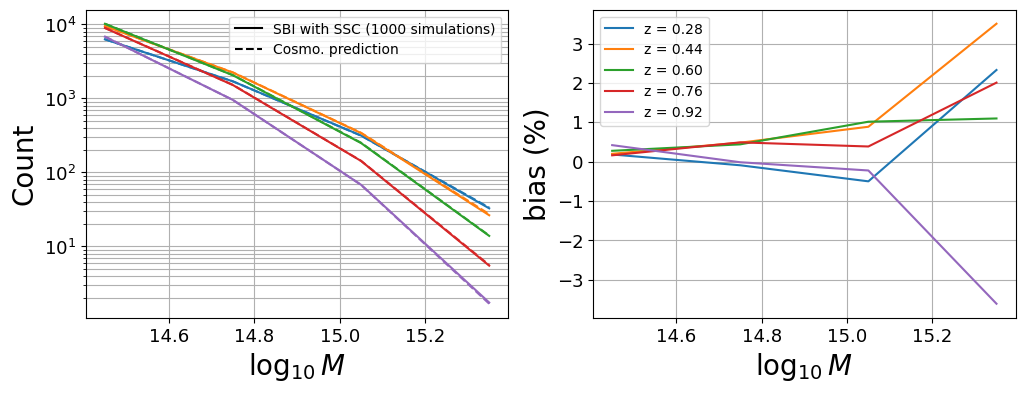

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(121)

for i in range(len(Z_bin)):
    from_sim =  np.mean(np.array(Ncount_obs).T[:,i], axis=1)
    from_pred = Ncount_th[i,:]
    plt.plot(np.mean(LogMass_bin, axis=1), from_pred, '-' + 'C' + str(i))
    plt.plot(np.mean(LogMass_bin, axis=1), from_sim, '--' + 'C' + str(i))
plt.ylabel('Count', fontsize=20,)
plt.xlabel(r'$\log_{10}M$', fontsize=20,)
plt.grid(which='both')
plt.tick_params(axis='both', which = 'major', labelsize= 13)
plt.legend(fontsize=12)
plt.yscale('log')
plt.plot([], [], ls='-', color='k', label = 'SBI with SSC (1000 simulations)')
plt.plot([], [], '--k', label = 'Cosmo. prediction')
plt.legend()

plt.subplot(122)

for i in range(len(Z_bin)):
    from_sim = np.mean(np.array(Ncount_obs).T[:,i], axis=1)
    from_pred = Ncount_th[i,:]
    plt.plot(np.mean(LogMass_bin, axis=1), 100*(from_sim- from_pred)/from_pred, '-' + 'C' + str(i),  label = 'z = '+f'{np.mean(Z_bin[i]):.2f}')
plt.ylabel('bias (%)', fontsize=20,)
plt.xlabel(r'$\log_{10}M$', fontsize=20,)
plt.grid(which='both')
plt.tick_params(axis='both', which = 'major', labelsize= 13)
plt.legend(fontsize=12)
plt.legend()

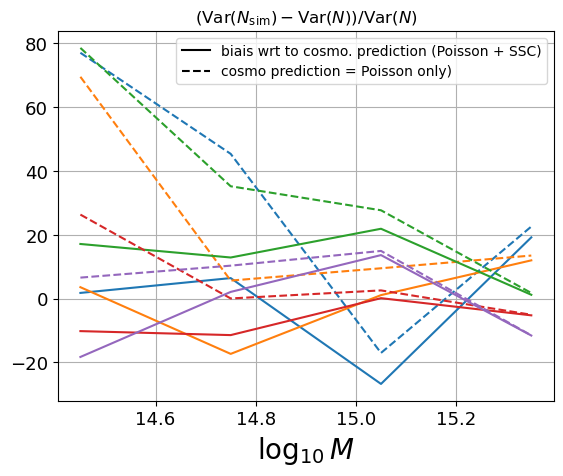

In [ ]:
plt.title(r'$(\mathrm{Var}( N_{\rm sim} ) - \mathrm{Var}(N))/\mathrm{Var}(N)$')
for i in range(len(Z_bin)):
    from_sim = np.std(np.array(Ncount_obs).T[:,i], axis=1)**2
    from_pred = Ncount_th[i,:] + Sample_covariance.diagonal()[i*len(LogMass_bin):(i+1)*len(LogMass_bin)]
    plt.plot(np.mean(LogMass_bin, axis=1), 100*(from_sim-from_pred)/from_pred, '-'+'C' + str(i))
    
    from_pred = Ncount_th[i,:]# + Sample_covariance.diagonal()[i*len(logMass_bin):(i+1)*len(logMass_bin)]
    plt.plot(np.mean(LogMass_bin, axis=1), 100*(from_sim-from_pred)/from_pred, '--'+'C' + str(i))
   
plt.plot([], [], ls='-', color='k', label = 'biais wrt to cosmo. prediction (Poisson + SSC)')
plt.plot([], [], ls='--', color='k', label = 'cosmo prediction = Poisson only')
plt.legend()

plt.xlabel(r'$\log_{10}M$', fontsize=20,)
plt.grid(which='both')
plt.tick_params(axis='both', which = 'major', labelsize= 13)

In [ ]:
# def generate_halo_catalogue(cosmo):
    
#     import model_halo_abundance as cl_count
#     clc = cl_count.ClusterAbundance()
#     clc.set_cosmology(cosmo = cosmo, hmd = stacked_simulator_pl.hmd, massdef = stacked_simulator_pl.massdef)
#     clc.sky_area = stacked_simulator_pl.f_sky * 4 * np.pi
#     dz_grid = z_grid[1] - z_grid[0]
#     logm_grid = np.linspace(14.3, 15.5, 1000)
#     dlogm_grid = logm_grid[1] - logm_grid[0]
#     clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
#     halobias_fct = ccl.halos.hbias.tinker10.HaloBiasTinker10(mass_def=stacked_simulator_pl.massdef)
#     clc.compute_halo_bias_grid_MZ(z_grid = z_grid, logm_grid = logm_grid, halobiais = halobias_fct)

#     bdNdm_zbins = []
#     dNdm_zbins = []
#     average_bias_zbins = []
#     cumulative_zbins = []
    
#     cov_ln1_plus_delta_SSC = np.log(1 + stacked_simulator_pl.Sij_SSC)
#     mean = - 0.5 * cov_ln1_plus_delta_SSC.diagonal()
#     ln1_plus_delta_SSC = np.random.multivariate_normal(mean=mean , cov=cov_ln1_plus_delta_SSC)
#     delta = (np.exp(ln1_plus_delta_SSC) - 1)
    
#     N_obs = np.zeros([len(stacked_simulator_pl.Z_bin_SSC), len(logm_grid)])
#     log10mass = []
#     redshift = []
#     for i, redshift_range in enumerate(stacked_simulator_pl.Z_bin_SSC):
        
#         mask = (z_grid >= redshift_range[0])*(z_grid <= redshift_range[1])
#         integrand = 4 * np.pi * stacked_simulator_pl.f_sky * clc.halo_biais * clc.dN_dzdlogMdOmega
#         bdNdm = np.trapz(integrand[:,mask], z_grid[mask])
#         dNdm  = stacked_simulator_pl.f_sky * 4 * np.pi * np.trapz(clc.dN_dzdlogMdOmega[:,mask], z_grid[mask], axis=1)
#         pdf   = stacked_simulator_pl.f_sky * 4 * np.pi * clc.dN_dzdlogMdOmega[:,mask]
#         cumulative = np.cumsum(dz_grid * pdf, axis = 1)
#         bias = np.array(bdNdm)/np.array(dNdm)
#         dN =  dNdm * dlogm_grid * (1 + bias * delta[i])
#         N_obs[i,:] = np.random.poisson(dN)
#         N_sample_obs_zbins = N_obs[i,:]
#         for j in range(len(logm_grid)):
#             log10mass.extend(list(np.zeros(int(N_sample_obs_zbins[j]))+logm_grid[j]))
#             cumulative_rand = (cumulative[j][-1]-cumulative[j][0])*np.random.random(int(N_sample_obs_zbins[j]))+cumulative[j][0]
#             redshift.extend(list(np.interp(cumulative_rand, cumulative[j], z_grid[mask])))
            
#     return np.array(redshift), np.array(log10mass)